In [1]:
from quspin.operators import hamiltonian,exp_op, quantum_operator # Hamiltonians and operators
from quspin.basis import spinless_fermion_basis_1d, spinless_fermion_basis_general # Hilbert space fermion basis
from quspin.tools.block_tools import block_diag_hamiltonian # block diagonalisation
from quspin.tools.measurements import ED_state_vs_time
from quspin.tools.evolution import expm_multiply_parallel
import numpy as np # generic math functions
import numba as nb
import matplotlib.pyplot as plt # plotting library
import copy
import matplotlib.pyplot as plt
import scipy
from scipy import sparse, interpolate
import sys,os

In [2]:
os.environ['KMP_DUPLICATE_LIB_OK']='True' # uncomment this line if omp error occurs on OSX for python 3
os.environ['OMP_NUM_THREADS']='16' # set number of OpenMP threads to run in parallel
os.environ['MKL_NUM_THREADS']='16' # set number of MKL threads to run in parallel
dtype_real = np.float64
dtype_cmplx = np.result_type(dtype_real,np.complex64)

In [3]:
#set parameters, L is number of qubits
L=10
a=1
m=1
g=0.6
hop=1
psi=np.zeros(2**L,dtype=np.complex128)
vac=np.zeros(2**L,dtype=np.complex128)
charge=int(L/2)
length=int(np.math.factorial(L)/(np.math.factorial(L-charge)*np.math.factorial(charge)))

In [4]:
#fermion field on lattice
def phi(n):
    basis=spinless_fermion_basis_1d(L)
    operator_list=[[1,n]]
    phi_dagger_list=[['+',operator_list]]
    phi_list=[['-',operator_list]]
    phi_dagger_dict=dict(H0=phi_dagger_list)
    phi_dict=dict(H0=phi_list)
    phi_dagger=quantum_operator(phi_dagger_dict,basis=basis,check_herm=False)
    phi=quantum_operator(phi_dict,basis=basis,check_herm=False)
    return phi_dagger,phi

In [6]:
#write down the Hamiltonian in Q=0 subspace
basis1=spinless_fermion_basis_1d(L,Nf=charge)
basis2=spinless_fermion_basis_1d(L)
hop_pm=[[-hop*1j/(2*a),i%L,(i+1)%L] for i in range(L)] #our hamiltonian
hop_mp=[[hop*1j/(2*a),(i+1)%L,i%L] for i in range(L)] #our hamiltonian
hmass_n=[[(-1)**i*m,i%L] for i in range(L)]
h_int_NJL1=[[-g/a,i%L] for i in range(L)]
h_int_NJL2=[[2*g/a,(2*i)%L,(2*i+1)%L] for i in range(int(L/2))]
J0_n=[[1,i] for i in range(L)]
static_ham=[["+-",hop_pm],["+-",hop_mp],['n',hmass_n]]
static_J0=[['n',J0_n]]
static_mass=[['n',hmass_n]]
static_h_int_NJL1=[['n',h_int_NJL1]]
static_h_int_NJL2=[['nn',h_int_NJL2]]
static_h_NJL=static_h_int_NJL2+static_h_int_NJL1+static_ham
dynamic=[]
ham=hamiltonian(static_h_NJL,dynamic,basis=basis1,dtype=np.complex128)
ham_fs=hamiltonian(static_h_NJL,dynamic,basis=basis2,dtype=np.complex128)
J0=hamiltonian(static_J0,dynamic,basis=basis1,dtype=np.float64)

Hermiticity check passed!
Particle conservation check passed!
Hermiticity check passed!
Hermiticity check passed!
Particle conservation check passed!


C:\Users\shilong\AppData\Local\Temp\ipykernel_43632\2940919277.py:17: UserWarning: Test for symmetries not implemented for <class 'quspin.basis.basis_1d.fermion.spinless_fermion_basis_1d'>, to turn off this warning set check_symm=False in hamiltonian
  ham=hamiltonian(static_h_NJL,dynamic,basis=basis1,dtype=np.complex128)
C:\Users\shilong\AppData\Local\Temp\ipykernel_43632\2940919277.py:18: UserWarning: Test for symmetries not implemented for <class 'quspin.basis.basis_1d.fermion.spinless_fermion_basis_1d'>, to turn off this warning set check_symm=False in hamiltonian
  ham_fs=hamiltonian(static_h_NJL,dynamic,basis=basis2,dtype=np.complex128)
C:\Users\shilong\AppData\Local\Temp\ipykernel_43632\2940919277.py:19: UserWarning: Test for symmetries not implemented for <class 'quspin.basis.basis_1d.fermion.spinless_fermion_basis_1d'>, to turn off this warning set check_symm=False in hamiltonian
  J0=hamiltonian(static_J0,dynamic,basis=basis1,dtype=np.float64)


In [7]:
#solve the vacuum state and qqbar state
E,V=ham.eigsh(which='SA',k=10)
E0,V0=ham.eigsh(which='SA',k=1)

In [10]:
#compute the hadron mass
Eng=[]
for i in range(len(E)):
    Eng.append([E[i]-E0[0],i])

print(Eng)

[[-1.0658141036401503e-14, 0], [2.28706502750747, 1], [2.316568623034022, 2], [2.3600057755955035, 3], [2.3165686230340565, 4], [2.360005775595501, 5], [3.1667452878232245, 6], [3.3313233869549963, 7], [3.210663889117625, 8], [3.2106638891176376, 9]]


In [11]:
#select the vacuum or qqbar state to compute the position space PDFs. We need to put it the full Hilbert space (dim=2**L).
p=1
for i in range(length):
    psi[2**L-1-basis1[i]]=V[:,p][i]
    vac[2**L-1-basis1[i]]=V[:,0][i]

In [12]:
#write down the full space Ham
basis2=spinless_fermion_basis_1d(L)
ham_fs=hamiltonian(static_h_NJL,dynamic,basis=basis2,dtype=np.complex128)
J0=hamiltonian(static_J0,dynamic,basis=basis2,dtype=np.float64)

Hermiticity check passed!
Hermiticity check passed!


C:\Users\shilong\AppData\Local\Temp\ipykernel_43632\3523470585.py:3: UserWarning: Test for symmetries not implemented for <class 'quspin.basis.basis_1d.fermion.spinless_fermion_basis_1d'>, to turn off this warning set check_symm=False in hamiltonian
  ham_fs=hamiltonian(static_h_NJL,dynamic,basis=basis2,dtype=np.complex128)
C:\Users\shilong\AppData\Local\Temp\ipykernel_43632\3523470585.py:4: UserWarning: Test for symmetries not implemented for <class 'quspin.basis.basis_1d.fermion.spinless_fermion_basis_1d'>, to turn off this warning set check_symm=False in hamiltonian
  J0=hamiltonian(static_J0,dynamic,basis=basis2,dtype=np.float64)


In [13]:
#compute the position space PDF
vol=a
P_mass=E[p]-E[0]
def light_cone_corr(psi,t1,z1,t2,z2,index_phi,index_corr):
    psi1=copy.deepcopy(psi)
    psi=expm_multiply_parallel(ham_fs.tocsr(),a=-1j*vol*t2,dtype=dtype_cmplx).dot(psi)
    psi=phi(2*z2+int(L/2-1)+(index_corr[1]+1)%2)[index_phi[1]].dot(psi)
    psi=expm_multiply_parallel(ham_fs.tocsr(),a=-1j*vol*(t1-t2),dtype=dtype_cmplx).dot(psi)
    psi=phi(2*z1+int(L/2-1)+(index_corr[0]+1)%2)[index_phi[0]].dot(psi)
    psi=expm_multiply_parallel(ham_fs.tocsr(),a=1j*vol*t1,dtype=dtype_cmplx).dot(psi)
    corr=np.dot(np.conjugate(psi1),psi)
    return corr

In [14]:
print(P_mass)

2.287065027507481


In [15]:
PDF_11=[]
PDF_12=[]
PDF_21=[]
PDF_22=[]
antiPDF_11=[]
antiPDF_12=[]
antiPDF_21=[]
antiPDF_22=[]
eps=0.001
for i in range(int(L/2)):
    PDF_11.append(light_cone_corr(psi,i-int((L/2-1)/2),-i+int((L/2-1)/2),0,0,[0,1],[1,1]))
    PDF_12.append(light_cone_corr(psi,i-int((L/2-1)/2),-i+int((L/2-1)/2),0,0,[0,1],[1,2]))
    PDF_21.append(light_cone_corr(psi,i-int((L/2-1)/2),-i+int((L/2-1)/2),0,0,[0,1],[2,1]))
    PDF_22.append(light_cone_corr(psi,i-int((L/2-1)/2),-i+int((L/2-1)/2),0,0,[0,1],[2,2]))
    antiPDF_11.append(light_cone_corr(psi,i-int((L/2-1)/2),-i+int((L/2-1)/2),0,0,[1,0],[1,1]))
    antiPDF_12.append(light_cone_corr(psi,i-int((L/2-1)/2),-i+int((L/2-1)/2),0,0,[1,0],[1,2]))
    antiPDF_21.append(light_cone_corr(psi,i-int((L/2-1)/2),-i+int((L/2-1)/2),0,0,[1,0],[2,1]))
    antiPDF_22.append(light_cone_corr(psi,i-int((L/2-1)/2),-i+int((L/2-1)/2),0,0,[1,0],[2,2]))

C:\Users\shilong\AppData\Local\Temp\ipykernel_43632\3243934668.py:9: UserWarning: Test for symmetries not implemented for <class 'quspin.basis.basis_1d.fermion.spinless_fermion_basis_1d'>, to turn off this warning set check_symm=False in hamiltonian
  phi_dagger=quantum_operator(phi_dagger_dict,basis=basis,check_herm=False)
C:\Users\shilong\AppData\Local\Temp\ipykernel_43632\3243934668.py:10: UserWarning: Test for symmetries not implemented for <class 'quspin.basis.basis_1d.fermion.spinless_fermion_basis_1d'>, to turn off this warning set check_symm=False in hamiltonian
  phi=quantum_operator(phi_dict,basis=basis,check_herm=False)


In [16]:
#transform to momentum space PDFs
def PDF_x(x): 
    PDF=0
    for i in range(int(L/2)):
        PDF=PDF+(np.exp(-1j*x*vol*P_mass*(i-int((L/2-1)/2)))*(PDF_11[i]+PDF_12[i]+PDF_21[i]+PDF_22[i]))
    return PDF

def antiPDF_x(x):
    PDF=0
    for i in range(int(L/2)):
        PDF=PDF+(np.exp(-1j*x*vol*P_mass*(i-int((L/2-1)/2)))*(antiPDF_11[i]+antiPDF_12[i]+antiPDF_21[i]+antiPDF_22[i]))
    return PDF

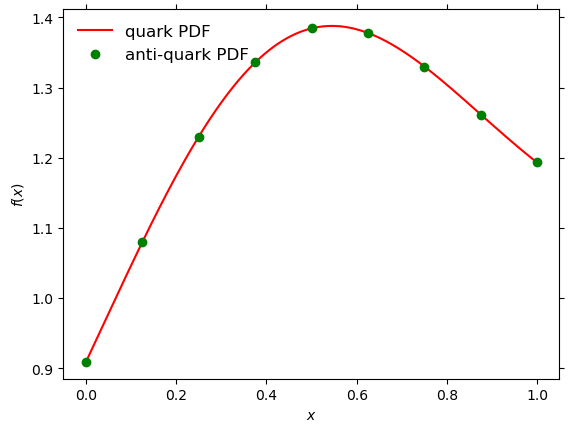

In [17]:
#draw the quark and anti-quark PDF, we will see they are the same in NJL model. (before subtract the vacuum)
PDF_fx=[]
antiPDF_fx=[]
x=[]
for i in range(1000):
    PDF_fx.append(np.real(PDF_x(0.001*i)))
    antiPDF_fx.append(np.real(antiPDF_x(0.001*i)))
    x.append(0.001*i)

fig,ax=plt.subplots()
plt.rcParams['xtick.direction']='in'
plt.rcParams['ytick.direction']='in'
plt.tick_params(top=True,bottom=True,left=True,right=True)
plt.plot(x,PDF_fx,color='red',label='quark PDF')
plt.plot(x,antiPDF_fx,'o',color='green',label='anti-quark PDF',markevery=[0,125,250,375,500,625,750,875,999])
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.legend(loc="upper left",prop={'size':12},frameon=False)
plt.show()

Fit the PDFs

In [42]:
#interpolate the lattice data
Re_data=np.real(np.array(PDF_11)+np.array(PDF_12)+np.array(PDF_21)+np.array(PDF_22))
Im_data=np.imag(np.array(PDF_11)+np.array(PDF_12)+np.array(PDF_21)+np.array(PDF_22))
ym=np.linspace(-a*(L/2-1)/2,a*(L/2-1)/2,int(L/2))
coti_ym=np.linspace(-a*(L/2-1)/2,a*(L/2-1)/2,1000)
fun_Re_inpol=interpolate.interp1d(ym,Re_data,kind="quadratic")
fun_Im_inpol=interpolate.interp1d(ym,Im_data,kind="quadratic")
num_Re_inpol=fun_Re_inpol(coti_ym)
num_Im_inpol=fun_Im_inpol(coti_ym)

In [43]:
#np.savetxt(fname='/home/lty/yin_research/NJL_PDF_code/NJL_PDF_result/quPDFN18ma08g1a1_11vac.txt',X=Re_data+1j*Im_data)

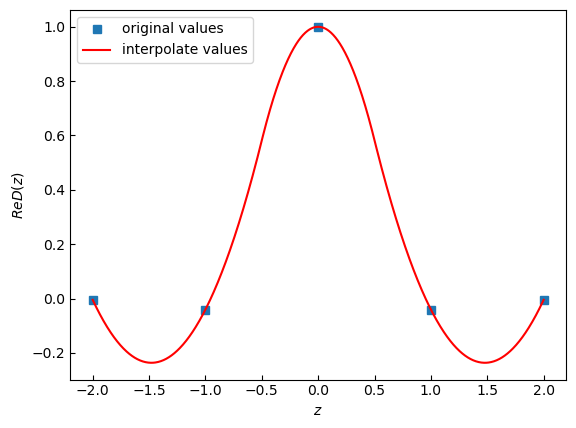

In [44]:
plot1 = plt.plot(ym, Re_data, 's',label='original values')
plot2 = plt.plot(coti_ym, num_Re_inpol, 'r',label='interpolate values')
plt.xlabel('$z$')
plt.ylabel('$ReD(z)$')
plt.legend(loc="upper left")
#plt.title('Re22')
plt.show()

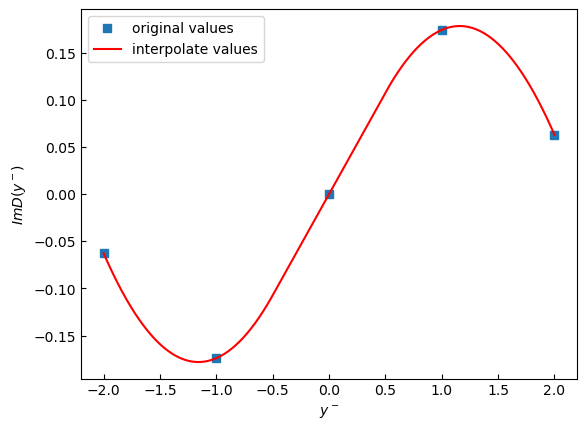

In [45]:
plot1 = plt.plot(ym, Im_data, 's',label='original values')
plot2 = plt.plot(coti_ym, num_Im_inpol, 'r',label='interpolate values')
plt.xlabel('$y^-$')
plt.ylabel('$ImD(y^-)$')
plt.legend(loc="upper left")
#plt.title('Im_11')
plt.show()

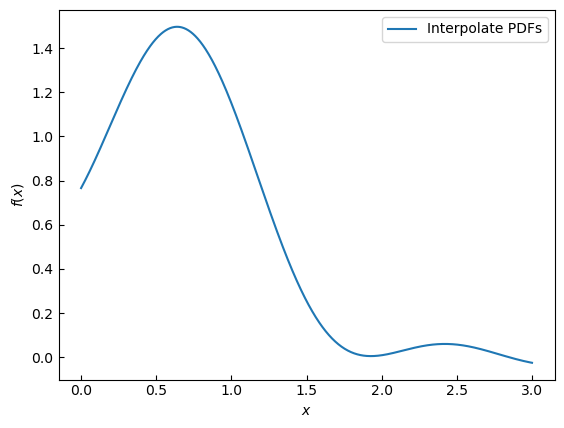

In [46]:
coti_x=np.linspace(0,3,1000)
inpol_PDFs=np.zeros(len(coti_x))
for i in range(len(coti_x)):
    inpol_PDFs[i]=np.real((coti_ym[1]-coti_ym[0])*np.dot(np.exp(-1j*P_mass*coti_ym*coti_x[i]),(num_Re_inpol+1j*num_Im_inpol)))

plot1 = plt.plot(coti_x, inpol_PDFs,label='Interpolate PDFs')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.legend(loc="upper right")
plt.show()

In [18]:
from quspin.operators import hamiltonian,quantum_operator # operators
from quspin.basis import spin_basis_1d # Hilbert spaces
import numpy as np # general math functions
from numpy.random import uniform
#
##### setting parameters for simulation
# physical parameters
L = 4 # system size
J = 1.0 # interaction strength
hx = np.sqrt(2) # transverse field strength
#
###### create the basis
basis = spin_basis_1d(L,pblock=1,pauli=False) # up basis
##### create model
# define static (fixed) site-coupling lists
J_list = [[J,i,(i+2)%L] for i in range(L)] # nnn interaction PBC
hx_list= [[hx,i] for i in range(L)] # onsite field
# create static lists for H0
operator_list_0 = [["zz", J_list], ["x", hx_list]]
# define parametric lists for H1 (corresponding to operators the coupling of which will be changed)
hz_list= [[1.0,i] for i in range(L)] # onsite field
operator_list_1 = [["z",hz_list]]
#
###### create operator dictionary for quantum_operator class
# add keys for TFI operators tring list and the longitudinal field
operator_dict=dict(H0=operator_list_0,H1=operator_list_1)
#
###### setting up `quantum_operator` hamiltonian dictionary
H = quantum_operator(operator_dict,basis=basis)
# print Hamiltonian H = H0 + H1
params_dict=dict(H0=1.0,H1=1.0) # dict containing the couplings to operators in keys of operator_dict
H_lmbda1 = H.tohamiltonian(params_dict)
print(H_lmbda1)
# change z-coupling strength: print Hamiltonian H = H0 + 2H1
params_dict=dict(H0=1.0,H1=2.0) # dict containing the couplings to operators in keys of operator_dict
H_lmbda2 = H.tohamiltonian(params_dict)
print(H_lmbda2)

Hermiticity check passed!
static mat: 
  (0, 0)	(3+0j)
  (0, 1)	(1.0000000000000002+0j)
  (0, 2)	(1.0000000000000002+0j)
  (1, 0)	(1.0000000000000002+0j)
  (1, 1)	(1+0j)
  (1, 3)	(0.7071067811865476+0j)
  (1, 4)	(0.7071067811865476+0j)
  (1, 7)	(1.0000000000000002+0j)
  (2, 0)	(1.0000000000000002+0j)
  (2, 2)	(1+0j)
  (2, 3)	(0.7071067811865476+0j)
  (2, 4)	(0.7071067811865476+0j)
  (2, 5)	(1.0000000000000002+0j)
  (3, 1)	(0.7071067811865476+0j)
  (3, 2)	(0.7071067811865476+0j)
  (3, 3)	(-1+0j)
  (3, 6)	(0.7071067811865476+0j)
  (3, 8)	(0.7071067811865476+0j)
  (4, 1)	(0.7071067811865476+0j)
  (4, 2)	(0.7071067811865476+0j)
  (4, 4)	(1+0j)
  (4, 6)	(0.7071067811865476+0j)
  (4, 8)	(0.7071067811865476+0j)
  (5, 2)	(1.0000000000000002+0j)
  (5, 5)	(-1+0j)
  (5, 6)	(1.0000000000000002+0j)
  (6, 3)	(0.7071067811865476+0j)
  (6, 4)	(0.7071067811865476+0j)
  (6, 5)	(1.0000000000000002+0j)
  (6, 6)	(-1+0j)
  (6, 9)	(1.0000000000000002+0j)
  (7, 1)	(1.0000000000000002+0j)
  (7, 7)	(-1+0j)
  (7

C:\Users\shilong\AppData\Local\Temp\ipykernel_43632\1536737846.py:29: UserWarning: Test for symmetries not implemented for <class 'quspin.basis.basis_1d.spin.spin_basis_1d'>, to turn off this warning set check_symm=False in hamiltonian
  H = quantum_operator(operator_dict,basis=basis)


In [19]:
print(J_list)

[[1.0, 0, 2], [1.0, 1, 3], [1.0, 2, 0], [1.0, 3, 1]]
